Set-up environment

In [115]:
!pip install gym-super-mario-bros
!pip install nes-py
!pip install stable-baselines3
!pip3 install torch torchvision torchaudio
!pip install opencv-python
!pip install tensorboard==2.2.0
import matplotlib 


In [116]:
# Import game mario bros
import gym_super_mario_bros as gym_mario

# Import joypad wrapper
from nes_py.wrappers import JoypadSpace

# Import simplified interface to work with game controller.
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT


In [117]:
# Set up environment for game 
train_env = gym_mario.make('SuperMarioBros2-v1')
train_env = JoypadSpace(train_env, COMPLEX_MOVEMENT)

In [17]:
# Create a flag - restart or not
done = True
# Loop through each frame in the game
for step in range(100000): 
    # Start the game to begin with 
    if done: 
        # Start the gamee
        train_env.reset()
    # Do random actions
    state, reward, done, info = train_env.step(train_env.action_space.sample())
    # Show the game on the screen
    train_env.render()
# Close the game
train_env.close()

C:\Users\meebo\anaconda3\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

In [18]:
train_env.close()

Colours of interface of super mario game is various - it's a combination of many colours-element colours -> it make agent hard to learn since it have to learn in each individual environment. Those environments has been set with element colours, agent learn in those env than combine it together to form a final result => we need to convert env to grey scale to make it's easier for our agent.

Now we deal with frames of game, agent will play game in many frames (surroundings like where coins are located, where Koopa appear...) - it's meaningless if agent just see and learn in single frame since it won't know the logic behind those surroundings -> we need framestack function to capure all frames from game and stack them together and let agent learn (FrameStack is used for stacking observations from a single environment)

In [118]:
# Import Framestack function to capture sequence of actions or frames (sequence of observations) of agent from an env 
from gym.wrappers import FrameStack
# Import greyscale
from gym.wrappers import GrayScaleObservation


Note that using Vectorized Environments (vec_env) is a must be when we use wrappers for frame-stacking. Vec_env is a method to stack multiple independent environments into a single environment. Instead of training an agent on 1 environment per step, it allows us to train it on n environments per step. 
In summary, VecFrameStack takes as input a vector of environments, each of which produces an observation, and stacks the observations from each environment into a single observation that is passed to the agent.

Dummy environment or Mock environment is a simplified, simulated environment that designed to mimic key feature of real environment. This env is for fast learning purpose.

In [119]:
# Import vectorization wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Vizualize impact of frames
from matplotlib import pyplot as pl

Preproccess observation space (environment).
Mario has simple play rule -> you can import SIMPLE_MOVEMENT instead of COMPLEX_MOVEMENT, but I want to test whether using COMPLEX_MOVEMENT can help my agent pass all the stages.

In this stage, environment or observation space is now preprocced and represented as grayscale images with an additional channel dimension

In [120]:
# Set up base environment
train_env = gym_mario.make('SuperMarioBros2-v1')
# Simplified the possible movement combinations. 
train_env = JoypadSpace(train_env, COMPLEX_MOVEMENT)
# Convert to grayscale
train_env = GrayScaleObservation(train_env,keep_dim=True)
# Wrap train_env into mock environment
train_env = DummyVecEnv([lambda: train_env])
# Stack the frames
train_env = VecFrameStack(train_env, 5, channels_order = 'last')

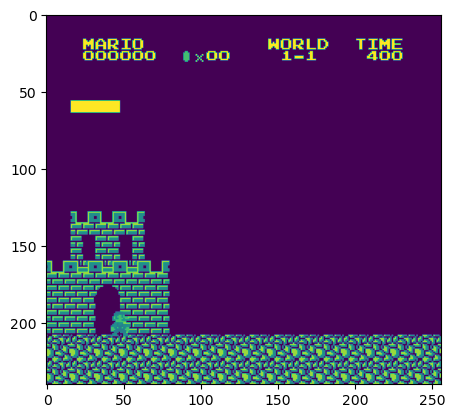

In [121]:
state = train_env.reset()
state, reward, done, info = train_env.step([5])
pl.imshow(state[0][:,:,3])

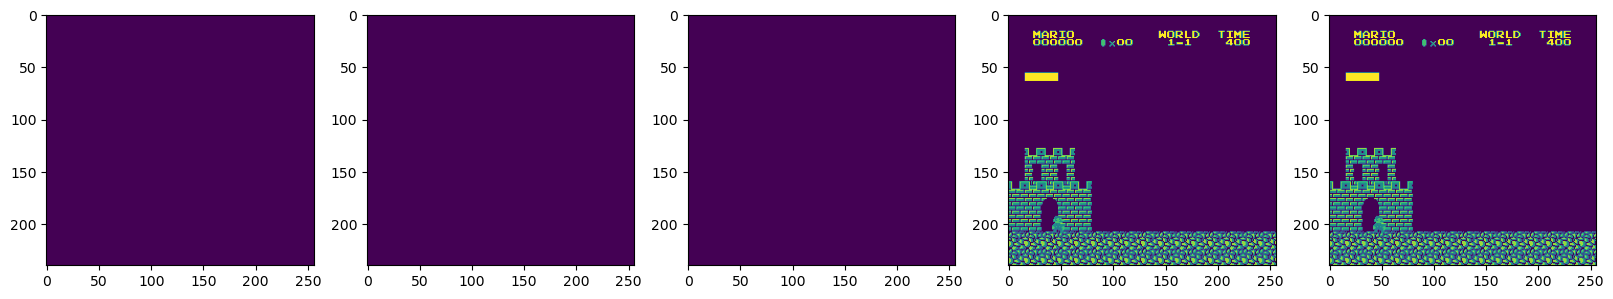

In [122]:
pl.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    pl.subplot(1,5,idx+1)
    pl.imshow(state[0][:,:,idx])
pl.show()

Train Reinforcement learning. 

In [123]:
# Import os to interact with the operating system
import os
# Import PPO
from stable_baselines3 import PPO
# Import BaseCallback to save model
from stable_baselines3.common.callbacks import BaseCallback

In [124]:
# Save model after agent finish each step (save the model during training)
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [125]:
CHECKPOINT_DIR = './train-models/'
LOG_DIR = './logs/'

In [126]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [127]:
# Create brain for agent
model_PPO = PPO('CnnPolicy', train_env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cpu device
Wrapping the env in a VecTransposeImage.


In [128]:
# Let model_PPO learn
model_PPO.learn(total_timesteps = 1000000, callback=callback)

ImportError: Trying to log data to tensorboard but tensorboard is not installed.

If you don't want to use # Save model after agent finish each step (save the model during training) then you can remove the part - callback=callback in # Let model_PPO learn

In [ ]:
model.save('thisisatestmodel')

Test model

In [ ]:
# Load model
model = PPO.load('./train/best_model_1000000')

state = env.reset()

# Start the game 
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

